In [1]:
#pip install torchsummary

In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # For mutliple devices (GPUs: 4, 5, 6, 7)
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from models import resnet

In [2]:
import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import torch.nn.functional as F
import random
from torchsummary import torchsummary
import higher

from jupyterplot import ProgressPlot
import numpy as np
import time
import mlogger
import utils
import argparse


Files already downloaded and verified


In [3]:
# import sys,os,argparse
# # def arg_parser():
    
# parser = argparse.ArgumentParser('MAML with Higher')

# # General
# general_params = parser.add_argument_group('General')
# general_params.add_argument('--data', type=str, default="./data",
#                             help='Path to the folder the data is downloaded to.')
# general_params.add_argument('--dataset', type=str,
#                             choices=["omniglot", "mini-imagenet", "fc100",
#                                      "cifarfs", "tiered-imagenet"], default='omniglot',
#                             help='Name of the dataset (default: omniglot).')

# meta_params = parser.add_argument_group('Meta Learning Parameters')
# meta_params.add_argument('--ways', type=int, default=5,
#                             help='Number of classes per task (N in "N-way", default: 5).')
# meta_params.add_argument('--shots', type=int, default=1,
#                             help='Number of training example per class (k in "k-shot", default: 5).')
# meta_params.add_argument('--adaptation-steps', type=int, default=1,
#                             help='Number of adaptation steps on meta-train datasets.')
# meta_params.add_argument('--num-tasks', type=int, default=32,
#                           help='Number of tasks to sample from task distribution.')
# meta_params.add_argument('--first-order', action='store_true',
#                           help='Use the first order approximation, do not use highers-order '
#                                'derivatives during meta-optimization.')
# meta_params.add_argument('--meta-lr', type=float, default=0.001,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--fast-lr', type=float, default=0.1,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--num-test-task', type=int, default=32,
#                             help='Number of test task used to calculate meta test and meta val')


# # Model
# model_params = parser.add_argument_group('Model')
# model_params.add_argument('--input', type=int, default=32,
#                           help='Input to dimension')
# model_params.add_argument('--fine-tune', type=int, default=0,
#                           help='Only meta learn the FC layer')

# # Optimization
# optim_params = parser.add_argument_group('Optimization')
# optim_params.add_argument('--num-epochs', type=int, default=50000,
#                           help='Number of epochs of meta-training (default: 50000).')
# optim_params.add_argument('--seed', type=int, default=utils.fix_seeds(),
#                           help='Number of epochs of meta-training (default: 101).')




# # Misc
# misc = parser.add_argument_group('Misc')
# misc.add_argument('--num-workers', type=int, default=4,
#                   help='Number of workers to use for data-loading (default: 1).')
# misc.add_argument('--device', type=str, default=utils.get_compute_device(), help="Compute device information")


# # Visualization
# viz = parser.add_argument_group('Misc')
# viz.add_argument('--wand_project', type=str, default="Github_Rapo",
#                   help='Wandb project name should go here')
# viz.add_argument('--username', type=str, default="hikmatkhan",
#                   help='Wandb username should go here')
# viz.add_argument('--wandb_logging', type=bool, default=True,
#                   help='If True, Logs will be reported on wandb.')
# viz.add_argument('--verbose', action='store_true')
# #     args = parser.parse_args()
# #     return parser.parse_args()
# # args = parser.parse_args()


In [4]:
# def main(argv):
#     print(argv)
    
# main(sys.argv)

In [5]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
    print("Device:", device)

Device: cuda


In [6]:
# #Dataset
# # transforms
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))])

# dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [8]:
# #MetaDataset MNIST or Custom Dataset
# dataset = l2l.data.MetaDataset(dataset)
# ways = 10
# shots = 1
# transforms = [
#     NWays(dataset, n=ways),
#     KShots(dataset, k=shots),
#     LoadData(dataset),
# ]
# tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# # MetaDataset Sampling
# for task in tasksets:
#     X, y = task
#     print(y)

In [9]:
#Builtin-MetaDatasets
dataset_name = "omniglot"
# "omniglot"
# "mini-imagenet", 
# "fc100", 
# "cifarfs", 
# "tiered-imagenet"

ways = 5
shots = 1
meta_batch= 8
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Separate data into adaptation/evalutation sets
# adaptation_indices = np.zeros(X.size(0), dtype=bool)
# adaptation_indices[np.arange(shots*ways) * 2] = True
# evaluation_indices = torch.from_numpy(~adaptation_indices)
# adaptation_indices = torch.from_numpy(adaptation_indices)


X.size: torch.Size([10, 1, 28, 28])


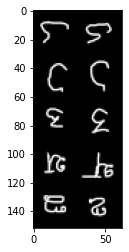

In [11]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [6]:
def get_indices(X, ways, shots):
    # Separate data into Meta-Train/Meta-Test sets
    meta_train_indices = np.zeros(X.size(0), dtype=bool)
    # print("X:", X.size())
    meta_train_indices[np.arange(shots * ways) * 2] = True
    meta_test_indices = torch.from_numpy(~meta_train_indices)
    meta_train_indices = torch.from_numpy(meta_train_indices)
    return meta_train_indices, meta_test_indices

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

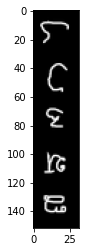

In [13]:
meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
#Adaptation Data
grid = utils.make_grid(X[meta_train_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

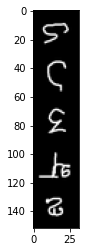

In [14]:
#Adaptation Data
grid = utils.make_grid(X[meta_test_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Validation: tensor([3, 3, 0, 0, 4, 4, 1, 1, 2, 2])


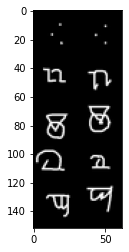

In [15]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Test: tensor([1, 1, 0, 0, 4, 4, 2, 2, 3, 3])


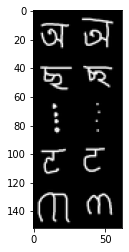

In [16]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [4]:
model = resnet.ResNet18S(out_dim=ways).to(device)
print(model)
# model = resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features

# num_ftrs 
# model.fc = nn.Linear(num_ftrs, ways).to(device)

# print(model(torch.rand((1,3,84,84)).to(device)))
# torchsummary.summary(model, input_size= (3, 84, 84))

NameError: name 'ways' is not defined

In [18]:
# print(model.conv1.weight[0].grad)

In [19]:


# def main(argv):
    

In [7]:

meta_lr_lst = [0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
fast_lr_lst = [0.1, 0.5, 0.9, 0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
adaptation_steps_lst = [1, 5]
shots_lst = [1, 5]
meta_batch_lst = [32]

epochs = 1000
ways = 5
dataset_name = "omniglot"
model = resnet.ResNet18S(out_dim=ways).to(device)

for meta_lr in meta_lr_lst:
    for fast_lr in fast_lr_lst:
        for adaptation_steps in adaptation_steps_lst:
            for shots in shots_lst:
                for meta_batch in meta_batch_lst:

        #             meta_lr = 0.005
        #             fast_lr = 0.01
        #             adaptation_steps = 1
                    optim_meta = optim.Adam(model.parameters(), lr=meta_lr)
                    epochs = 1000
                    # pp = ProgressPlot(plot_names=["ACC", "LOSS"],
                    #                   line_names=["SS", "QS"])
                    tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)



                    WANDB_LOGGER = True
                    if(WANDB_LOGGER):
                        import wandb
                        wandb.init(project="JOmniGlot", entity="hikmatkhan-", reinit=True)
                        wandb.watch(model, log_freq=10)
                        wandb.log({"Dataset":dataset_name,
                                  "Ways":ways,
                                  "Shots":shots,
                                  "Meta Batch": meta_batch,
                                  "Meta_lr": meta_lr,
                                  "Fast_lr": fast_lr,
                                  "Adaptation Step": adaptation_steps})
        #             if __name__ == "__main__":

                #     meta_train_spt_loss = mlogger.metric.Average()
                #     meta_train_spt_acc = mlogger.metric.Average()
                #     meta_train_qry_loss = mlogger.metric.Average()
                #     meta_train_qry_acc = mlogger.metric.Average()

                    for e in range(epochs):
                        optim_meta.zero_grad()
                        model.train()
                        meta_train_loss = mlogger.metric.Average()
                        meta_train_acc = mlogger.metric.Average()
                        meta_val_loss = mlogger.metric.Average()
                        meta_val_acc = mlogger.metric.Average()
                        meta_test_loss = mlogger.metric.Average()
                        meta_test_acc = mlogger.metric.Average()
                        for t in range(meta_batch):
                            X, y = tasksets.train.sample()

                            X, y = X.to(device), y.to(device)
                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast, copy_initial_weights=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_train_spt_loss = F.cross_entropy(y_prd, y[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_train_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X[meta_test_indices])
                                meta_train_acc.update(accuracy(y_prd, y[meta_test_indices]))
                                meta_train_qry_loss = F.cross_entropy(y_prd, y[meta_test_indices])
                                meta_train_loss.update(meta_train_qry_loss.detach().cpu().item())

                                meta_train_qry_loss.backward()


                        optim_meta.step()
                        if(WANDB_LOGGER):
                            wandb.log({"Meta Update": e})
                        print("Meta-Update")

                        for t in range(meta_batch):
                            model.eval()
                            X_val, y_val = tasksets.validation.sample()
                            X_val, y_val = X_val.to(device), y_val.to(device)

                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X_val, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_val[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_val_spt_loss = F.cross_entropy(y_prd, y_val[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_val_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_val[meta_test_indices])
                                meta_val_acc.update(accuracy(y_prd, y_val[meta_test_indices]))
                                meta_val_qry_loss = F.cross_entropy(y_prd, y_val[meta_test_indices])
                                meta_val_loss.update(meta_val_qry_loss.detach().cpu().item())



                        for t in range(meta_batch):
                            model.eval()
                            X_test, y_test = tasksets.test.sample()
                            X_test, y_test = X_test.to(device), y_test.to(device)

                            meta_train_indices, meta_test_indices = get_indices(X=X_test, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_test[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_test_spt_loss = F.cross_entropy(y_prd, y_test[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_test_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_test[meta_test_indices])
                                meta_test_acc.update(accuracy(y_prd, y_test[meta_test_indices]))
                                meta_test_qry_loss = F.cross_entropy(y_prd, y_test[meta_test_indices])
                                meta_test_loss.update(meta_test_qry_loss.detach().cpu().item())


                #                 meta_train_qry_loss.backward()

                        if(WANDB_LOGGER):
                            wandb.log({
                                   "Meta Train Acc": meta_train_acc.value,
                                   "Meta Train Loss": meta_train_loss.value,
                                    "Meta Val Acc": meta_val_acc.value,
                                    "Meta Val Loss": meta_val_loss.value,
                                    "Meta Test Acc": meta_test_acc.value,
                                    "Meta Test Loss": meta_test_loss.value
                                   })
                        print("Epoch|", e, "|", "Meta Train Acc:", meta_train_acc.value, " Meta Train Loss:", meta_train_loss.value,
                             "Meta Val Acc:", meta_val_acc.value, " Meta Val Loss:", meta_val_loss.value,
                             "Meta Test Acc:", meta_test_acc.value, " Meta Test Loss:", meta_test_loss.value)


                        meta_train_loss.reset()
                        meta_train_acc.reset()
                        meta_val_loss.reset()
                        meta_val_acc.reset()
                        meta_test_loss.reset()
                        meta_test_acc.reset()

                
    

Files already downloaded and verified
Files already downloaded and verified


wandb: Currently logged in as: hikmatkhan- (use `wandb login --relogin` to force relogin)


Meta-Update
Epoch| 0 | Meta Train Acc: 0.21250000316649678  Meta Train Loss: 9.170303151011469 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1680316823084986e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.252412820854879e+19
Meta-Update
Epoch| 1 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 12.753455266356468 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3127269490968497e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3274565888306058e+18
Meta-Update
Epoch| 2 | Meta Train Acc: 0.1937500028871  Meta Train Loss: 10.790760762989521 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.314211596760515e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.312788408344248e+17
Meta-Update
Epoch| 3 | Meta Train Acc: 0.19375000288710006  Meta Train Loss: 11.325898706912994 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.333736127823874e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.132496643129343e+16
Meta-Update
Epoch| 4 | Meta Train 

Meta-Update
Epoch| 34 | Meta Train Acc: 0.20625000307336455  Meta Train Loss: 10.313089534640314 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.685503652069376e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.704819884962611e+16
Meta-Update
Epoch| 35 | Meta Train Acc: 0.23125000344589353  Meta Train Loss: 8.862317979335788 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.4587706306592772e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.850707804146891e+16
Meta-Update
Epoch| 36 | Meta Train Acc: 0.21250000363215807  Meta Train Loss: 9.494706414639952 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.2434427472642052e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.295284700381184e+16
Meta-Update
Epoch| 37 | Meta Train Acc: 0.19375000288710004  Meta Train Loss: 9.451965913176535 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.864632520559821e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.0322989740326916e+16
Meta-Update
Epoch| 38 | Meta

Meta-Update
Epoch| 68 | Meta Train Acc: 0.218750003259629  Meta Train Loss: 8.676847882568834 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.6116842334453764e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.8838517811445772e+16
Meta-Update
Epoch| 69 | Meta Train Acc: 0.21250000409781936  Meta Train Loss: 7.897151142358779 Meta Val Acc: 0.20625000307336452  Meta Val Loss: 2.754886116992614e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.9048317132406788e+16
Meta-Update
Epoch| 70 | Meta Train Acc: 0.23125000344589347  Meta Train Loss: 7.570585530251264 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.7466180700667908e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.9862006806806524e+16
Meta-Update
Epoch| 71 | Meta Train Acc: 0.2625000039115549  Meta Train Loss: 8.626828230917452 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.7738551084908544e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.04803542550446e+16
Meta-Update
Epoch| 72 | Meta T

Meta-Update
Epoch| 103 | Meta Train Acc: 0.30000000540167104  Meta Train Loss: 5.8916002959013 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 387824545693696.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 435013431590912.06
Meta-Update
Epoch| 104 | Meta Train Acc: 0.218750003259629  Meta Train Loss: 6.273880694061519 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 364317290528768.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 413022649057280.0
Meta-Update
Epoch| 105 | Meta Train Acc: 0.1875000027939677  Meta Train Loss: 7.31175672262907 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 323074460745728.06 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 379604998553599.8
Meta-Update
Epoch| 106 | Meta Train Acc: 0.23750000400468707  Meta Train Loss: 6.871493503451348 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 334167249256447.94 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 331788829851648.06
Meta-Update
Epoch| 107 | Meta Train Acc: 0.24375000363215815  

Meta-Update
Epoch| 138 | Meta Train Acc: 0.2562500042840838  Meta Train Loss: 5.836976371705531 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 73750374645760.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 79705316851712.0
Meta-Update
Epoch| 139 | Meta Train Acc: 0.23125000344589358  Meta Train Loss: 6.353976622223853 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 80247609753600.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 80743082950655.97
Meta-Update
Epoch| 140 | Meta Train Acc: 0.23125000391155473  Meta Train Loss: 5.979687638580801 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 85079628578816.02 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 83541313716224.0
Meta-Update
Epoch| 141 | Meta Train Acc: 0.1812500027008354  Meta Train Loss: 6.221732579171661 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 72745391685631.98 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 89679389130751.98
Meta-Update
Epoch| 142 | Meta Train Acc: 0.21250000363215804  Meta

Meta-Update
Epoch| 173 | Meta Train Acc: 0.24375000363215807  Meta Train Loss: 5.72698375955224 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 18186563502080.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 19325588766720.0
Meta-Update
Epoch| 174 | Meta Train Acc: 0.22500000381842256  Meta Train Loss: 5.038266114890575 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 17812917764096.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 18723250634752.0
Meta-Update
Epoch| 175 | Meta Train Acc: 0.2500000041909516  Meta Train Loss: 4.870348814874887 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 18521709969408.008 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 20034404007936.004
Meta-Update
Epoch| 176 | Meta Train Acc: 0.2562500038184226  Meta Train Loss: 4.541766408830882 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 17975826989056.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 16780417089536.0
Meta-Update
Epoch| 177 | Meta Train Acc: 0.23750000353902578  Meta 

Meta-Update
Epoch| 208 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 5.223371744155884 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 39232398098432.01 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 40462446460927.99
Meta-Update
Epoch| 209 | Meta Train Acc: 0.18125000316649673  Meta Train Loss: 5.666037939488888 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 43578199932928.01 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 43765430976512.01
Meta-Update
Epoch| 210 | Meta Train Acc: 0.2312500034458935  Meta Train Loss: 4.756439544260502 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 41547545575423.99 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 38189818052607.99
Meta-Update
Epoch| 211 | Meta Train Acc: 0.2562500042840839  Meta Train Loss: 4.810363795608283 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 50629495259136.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 44684224561151.99
Meta-Update
Epoch| 212 | Meta Train Acc: 0.24375000409781936  M

Meta-Update
Epoch| 243 | Meta Train Acc: 0.23750000400468707  Meta Train Loss: 4.517593882977962 Meta Val Acc: 0.20625000307336447  Meta Val Loss: 129964677791743.97 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 129827637559295.98
Meta-Update
Epoch| 244 | Meta Train Acc: 0.18750000279396772  Meta Train Loss: 4.397214174270631 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 130986174578687.98 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 133423777185791.98
Meta-Update
Epoch| 245 | Meta Train Acc: 0.2187500037252903  Meta Train Loss: 5.485517513006927 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 120021729017856.03 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 130094367637504.05
Meta-Update
Epoch| 246 | Meta Train Acc: 0.22500000335276138  Meta Train Loss: 4.911669485270978 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 121206678749184.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 140351456411647.95
Meta-Update
Epoch| 247 | Meta Train Acc: 0.20625000353

Meta-Update
Epoch| 278 | Meta Train Acc: 0.22500000381842253  Meta Train Loss: 4.3226617127656946 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 87598483767295.95 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 92288959447040.0
Meta-Update
Epoch| 279 | Meta Train Acc: 0.22500000381842256  Meta Train Loss: 4.041035387665033 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 96713405038592.02 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 100803848830975.95
Meta-Update
Epoch| 280 | Meta Train Acc: 0.22500000335276132  Meta Train Loss: 4.166689921170472 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 101574276546560.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 100877370785791.98
Meta-Update
Epoch| 281 | Meta Train Acc: 0.23750000447034839  Meta Train Loss: 4.43989510089159 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 102673583439871.97 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 112273965187071.98
Meta-Update
Epoch| 282 | Meta Train Acc: 0.23125000344589

Meta-Update
Epoch| 313 | Meta Train Acc: 0.2562500042840839  Meta Train Loss: 4.157265841960908 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 38164008402944.01 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 37711035891711.99
Meta-Update
Epoch| 314 | Meta Train Acc: 0.2250000038184226  Meta Train Loss: 3.854654490947724 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 39321083183104.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 42498343501823.99
Meta-Update
Epoch| 315 | Meta Train Acc: 0.23125000344589347  Meta Train Loss: 3.6360296271741395 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 43044423335936.016 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 41090638938112.01
Meta-Update
Epoch| 316 | Meta Train Acc: 0.23125000344589353  Meta Train Loss: 4.161227077245712 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 46446095368191.984 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 48310703882240.016
Meta-Update
Epoch| 317 | Meta Train Acc: 0.2375000040046871

Meta-Update
Epoch| 348 | Meta Train Acc: 0.20625000353902578  Meta Train Loss: 3.6040817834436907 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 46501049925631.984 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 51655901577215.98
Meta-Update
Epoch| 349 | Meta Train Acc: 0.18750000279396775  Meta Train Loss: 4.028747744858265 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 39855851798528.01 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 41758576738303.984
Meta-Update
Epoch| 350 | Meta Train Acc: 0.1812500027008355  Meta Train Loss: 3.8971307687461363 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 41113339625472.016 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 37886666211328.0
Meta-Update
Epoch| 351 | Meta Train Acc: 0.2625000053085387  Meta Train Loss: 3.406053625047207 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 44771140960256.02 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 39644804546560.01
Meta-Update
Epoch| 352 | Meta Train Acc: 0.181250002700835

Meta-Update
Epoch| 383 | Meta Train Acc: 0.2250000042840839  Meta Train Loss: 3.545103520154953 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 118183840972800.02 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 130477824409599.95
Meta-Update
Epoch| 384 | Meta Train Acc: 0.22500000428408387  Meta Train Loss: 3.489366501569748 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 118063364833280.03 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 123439544270848.0
Meta-Update
Epoch| 385 | Meta Train Acc: 0.22500000381842253  Meta Train Loss: 3.2430792041122904 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 113500137193472.03 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 118277092802559.97
Meta-Update
Epoch| 386 | Meta Train Acc: 0.21875000372529027  Meta Train Loss: 3.737041637301445 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 108552081899520.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 128598114304000.03
Meta-Update
Epoch| 387 | Meta Train Acc: 0.19375000288

Meta-Update
Epoch| 418 | Meta Train Acc: 0.2500000041909517  Meta Train Loss: 3.2442790232598786 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 71858802130944.0 Meta Test Acc: 0.1937500028871  Meta Test Loss: 69657542524928.01
Meta-Update
Epoch| 419 | Meta Train Acc: 0.2687500040046872  Meta Train Loss: 3.221694674342871 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 74999513743360.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 67068768419839.99
Meta-Update
Epoch| 420 | Meta Train Acc: 0.23125000391155487  Meta Train Loss: 3.655495926737786 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 64063507070976.0 Meta Test Acc: 0.1937500028871  Meta Test Loss: 65592298307583.99
Meta-Update
Epoch| 421 | Meta Train Acc: 0.26875000540167093  Meta Train Loss: 3.302867982536554 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 75592648622079.98 Meta Test Acc: 0.20625000307336447  Meta Test Loss: 69180826583039.984
Meta-Update
Epoch| 422 | Meta Train Acc: 0.21875000325962904  Meta Trai

Meta-Update
Epoch| 453 | Meta Train Acc: 0.21875000325962898  Meta Train Loss: 2.8689252585172658 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 45230903328768.016 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 45731548168192.01
Meta-Update
Epoch| 454 | Meta Train Acc: 0.16875000251457098  Meta Train Loss: 3.297296892851591 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 34763363975167.992 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 37131060641792.0
Meta-Update
Epoch| 455 | Meta Train Acc: 0.24375000363215799  Meta Train Loss: 2.8704864047467704 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 36840324268032.016 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 42470607159296.0
Meta-Update
Epoch| 456 | Meta Train Acc: 0.1750000026077033  Meta Train Loss: 3.184447400271892 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 43427372597247.97 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 50225277304832.01
Meta-Update
Epoch| 457 | Meta Train Acc: 0.206250003073364

Meta-Update
Epoch| 488 | Meta Train Acc: 0.21250000363215804  Meta Train Loss: 2.793752767145634 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 10220343295999.996 Meta Test Acc: 0.20625000307336452  Meta Test Loss: 9400151719936.0
Meta-Update
Epoch| 489 | Meta Train Acc: 0.26875000493600965  Meta Train Loss: 2.820101141929627 Meta Val Acc: 0.20625000307336452  Meta Val Loss: 7834298318848.001 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7073519755263.997
Meta-Update
Epoch| 490 | Meta Train Acc: 0.23750000353902584  Meta Train Loss: 2.613548658788204 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7051563753472.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6818109202431.999
Meta-Update
Epoch| 491 | Meta Train Acc: 0.2500000037252904  Meta Train Loss: 2.620640248060226 Meta Val Acc: 0.1937500028871  Meta Val Loss: 6595911868416.001 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7043211640832.0
Meta-Update
Epoch| 492 | Meta Train Acc: 0.23750000400468713  Meta Tra

Meta-Update
Epoch| 524 | Meta Train Acc: 0.24375000409781933  Meta Train Loss: 2.6400587558746333 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6337327169535.998 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6649803677695.999
Meta-Update
Epoch| 525 | Meta Train Acc: 0.23750000400468704  Meta Train Loss: 2.8554010912775993 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7715636994047.999 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7584584425472.0
Meta-Update
Epoch| 526 | Meta Train Acc: 0.2312500043772161  Meta Train Loss: 2.541255589574575 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7337702432767.999 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8088390205439.999
Meta-Update
Epoch| 527 | Meta Train Acc: 0.2500000046566128  Meta Train Loss: 2.2882347553968434 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6627003154432.0 Meta Test Acc: 0.1937500028871  Meta Test Loss: 7307875491839.997
Meta-Update
Epoch| 528 | Meta Train Acc: 0.2375000044703484  Meta T

Meta-Update
Epoch| 559 | Meta Train Acc: 0.2750000040978194  Meta Train Loss: 2.3428249843418585 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 43190446784512.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 45959562133503.984
Meta-Update
Epoch| 560 | Meta Train Acc: 0.26250000391155487  Meta Train Loss: 2.5412565991282468 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 40509682286592.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 45918276747264.0
Meta-Update
Epoch| 561 | Meta Train Acc: 0.22500000428408382  Meta Train Loss: 2.347063828259706 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 39707067940864.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 41761333772287.99
Meta-Update
Epoch| 562 | Meta Train Acc: 0.21875000325962904  Meta Train Loss: 2.3852982558310027 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 31389042671615.996 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 31921949507584.004
Meta-Update
Epoch| 563 | Meta Train Acc: 0.2312500039115548

Meta-Update
Epoch| 594 | Meta Train Acc: 0.2687500044703483  Meta Train Loss: 2.3227482549846172 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 11895601151999.994 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 12622315585536.002
Meta-Update
Epoch| 595 | Meta Train Acc: 0.2625000043772162  Meta Train Loss: 2.6402211748063578 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13051977859072.004 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 14301645258752.002
Meta-Update
Epoch| 596 | Meta Train Acc: 0.25000000465661293  Meta Train Loss: 2.6006835252046594 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13980709634048.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 14364182937600.0
Meta-Update
Epoch| 597 | Meta Train Acc: 0.24375000456348056  Meta Train Loss: 2.516874179244042 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 13702763479040.002 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 14685688758272.0
Meta-Update
Epoch| 598 | Meta Train Acc: 0.26875000493600

Meta-Update
Epoch| 629 | Meta Train Acc: 0.22500000381842253  Meta Train Loss: 2.8111717067658915 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 302622915428352.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 332467405848575.94
Meta-Update
Epoch| 630 | Meta Train Acc: 0.2437500045634807  Meta Train Loss: 2.398517251014709 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 288777624879104.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 325383064387583.94
Meta-Update
Epoch| 631 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 2.6841080971062192 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 308195765518335.94 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 311537020960768.1
Meta-Update
Epoch| 632 | Meta Train Acc: 0.2500000037252904  Meta Train Loss: 2.550401229411363 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 294022256001023.94 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 311345926373376.1
Meta-Update
Epoch| 633 | Meta Train Acc: 0.2562500047497

Meta-Update
Epoch| 664 | Meta Train Acc: 0.21250000316649667  Meta Train Loss: 2.229542512446642 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 167352854118399.97 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 164768090423296.03
Meta-Update
Epoch| 665 | Meta Train Acc: 0.23750000400468704  Meta Train Loss: 2.44545653089881 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 152615112146944.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 164068225974271.97
Meta-Update
Epoch| 666 | Meta Train Acc: 0.21875000325962904  Meta Train Loss: 2.298184793442488 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 156894643355648.0 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 158250083811327.97
Meta-Update
Epoch| 667 | Meta Train Acc: 0.23125000344589347  Meta Train Loss: 2.381560176610947 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 156057071255552.03 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 148577747599360.0
Meta-Update
Epoch| 668 | Meta Train Acc: 0.2562500042840

Meta-Update
Epoch| 699 | Meta Train Acc: 0.1937500028871  Meta Train Loss: 7.444236315786838 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.222607978379224e+21 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.509087173106826e+21
Meta-Update
Epoch| 700 | Meta Train Acc: 0.16875000251457095  Meta Train Loss: 7.74095058441162 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.5089027454244267e+21 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.8881548986559014e+21
Meta-Update
Epoch| 701 | Meta Train Acc: 0.18125000316649675  Meta Train Loss: 8.979383446276186 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.011308865118441e+21 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.364425081599911e+21
Meta-Update
Epoch| 702 | Meta Train Acc: 0.1625000024214387  Meta Train Loss: 8.84082369878888 Meta Val Acc: 0.20625000307336452  Meta Val Loss: 4.178838575520252e+21 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.0582392363639206e+21
Meta-Update
Epoch| 703 | Meta Tr

Meta-Update
Epoch| 733 | Meta Train Acc: 0.20625000307336452  Meta Train Loss: 6.855251543223858 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.714509904941187e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.5770385433639564e+20
Meta-Update
Epoch| 734 | Meta Train Acc: 0.20625000353902584  Meta Train Loss: 5.790633235126733 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.568279298875107e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.184281497052622e+20
Meta-Update
Epoch| 735 | Meta Train Acc: 0.23125000344589353  Meta Train Loss: 5.782915465533733 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1545308886386031e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3068628075106165e+20
Meta-Update
Epoch| 736 | Meta Train Acc: 0.2500000041909517  Meta Train Loss: 5.59152564033866 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.393051831325216e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.1965115459572834e+19
Meta-Update
Epoch| 737 | M

Meta-Update
Epoch| 767 | Meta Train Acc: 0.21875000419095164  Meta Train Loss: 6.47366453334689 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.280338961163875e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.601999262508645e+16
Meta-Update
Epoch| 768 | Meta Train Acc: 0.23125000344589358  Meta Train Loss: 5.858001671731474 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.5357823965724672e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3824388500344011e+17
Meta-Update
Epoch| 769 | Meta Train Acc: 0.22500000381842256  Meta Train Loss: 5.205150131136178 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4307271750608485e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1827614499785931e+17
Meta-Update
Epoch| 770 | Meta Train Acc: 0.2437500036321581  Meta Train Loss: 5.692762091755867 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1640309244598683e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.505102562695578e+17
Meta-Update
Epoch| 771 | 

Meta-Update
Epoch| 801 | Meta Train Acc: 0.25625000381842256  Meta Train Loss: 5.508053664118051 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2876046325786875e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3565395099776456e+18
Meta-Update
Epoch| 802 | Meta Train Acc: 0.2562500052154064  Meta Train Loss: 5.060137495398522 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.897100674851145e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.150194671828338e+17
Meta-Update
Epoch| 803 | Meta Train Acc: 0.21250000316649673  Meta Train Loss: 5.2891857102513296 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.820665442788965e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4725710571508854e+18
Meta-Update
Epoch| 804 | Meta Train Acc: 0.24375000456348064  Meta Train Loss: 4.916154809296131 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0067512240719789e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2344124445546248e+18
Meta-Update
Epoch| 805 

Meta-Update
Epoch| 835 | Meta Train Acc: 0.23750000353902578  Meta Train Loss: 4.729707617312671 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.326715978091856e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2980029255697042e+18
Meta-Update
Epoch| 836 | Meta Train Acc: 0.27500000502914185  Meta Train Loss: 4.4865561425685865 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6122397823546163e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.517866988871876e+18
Meta-Update
Epoch| 837 | Meta Train Acc: 0.16250000242143872  Meta Train Loss: 6.208535455167294 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.1959845672638223e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.8943607479163945e+18
Meta-Update
Epoch| 838 | Meta Train Acc: 0.25625000428408395  Meta Train Loss: 3.64821346849203 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.8201418436569987e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0769128159473825e+18
Meta-Update
Epoch| 839

Meta-Update
Epoch| 869 | Meta Train Acc: 0.2125000031664968  Meta Train Loss: 4.052520971745253 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.482553580437111e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.159013334738796e+18
Meta-Update
Epoch| 870 | Meta Train Acc: 0.23750000353902584  Meta Train Loss: 4.20408346131444 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.336484617519891e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.047972974036517e+18
Meta-Update
Epoch| 871 | Meta Train Acc: 0.2687500040046871  Meta Train Loss: 3.8998091965913773 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.976052648475097e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.208476540351546e+18
Meta-Update
Epoch| 872 | Meta Train Acc: 0.2687500040046871  Meta Train Loss: 3.1864681728184228 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.259258773370565e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.474583561436399e+18
Meta-Update
Epoch| 873 | Meta 

Meta-Update
Epoch| 903 | Meta Train Acc: 0.268750004004687  Meta Train Loss: 3.474704880267382 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7891681082550518e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.1197429030592184e+18
Meta-Update
Epoch| 904 | Meta Train Acc: 0.24375000363215807  Meta Train Loss: 3.6181404367089263 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.8862242104732552e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.9312757287587679e+18
Meta-Update
Epoch| 905 | Meta Train Acc: 0.2687500049360097  Meta Train Loss: 3.5395719148218623 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6803413539569009e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5905716369128156e+18
Meta-Update
Epoch| 906 | Meta Train Acc: 0.1812500027008355  Meta Train Loss: 4.477615084499121 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.5993275354835848e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.7495981160692447e+18
Meta-Update
Epoch| 907

Meta-Update
Epoch| 937 | Meta Train Acc: 0.26250000484287744  Meta Train Loss: 3.2344656288623814 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.455444988110307e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.888114597543804e+18
Meta-Update
Epoch| 938 | Meta Train Acc: 0.25000000419095164  Meta Train Loss: 2.980905055999756 Meta Val Acc: 0.19375000288709998  Meta Val Loss: 4.9808360136822e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.702334238158749e+18
Meta-Update
Epoch| 939 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.361327946186065 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.563547085862601e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.642171570418614e+18
Meta-Update
Epoch| 940 | Meta Train Acc: 0.19375000335276127  Meta Train Loss: 3.5764440335333356 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.067001292578882e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.815393197808681e+18
Meta-Update
Epoch| 941 | Met

Meta-Update
Epoch| 971 | Meta Train Acc: 0.24375000456348062  Meta Train Loss: 3.4160411804914483 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.000221391522365e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.141354648229118e+18
Meta-Update
Epoch| 972 | Meta Train Acc: 0.26875000447034836  Meta Train Loss: 3.2958062216639514 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.5897193137027154e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.565200642489974e+18
Meta-Update
Epoch| 973 | Meta Train Acc: 0.2062500035390258  Meta Train Loss: 3.7361079864203934 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.3607125937828664e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.490911357675242e+18
Meta-Update
Epoch| 974 | Meta Train Acc: 0.23750000353902578  Meta Train Loss: 3.5655070096254344 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.314030422443951e+18 Meta Test Acc: 0.20625000307336447  Meta Test Loss: 4.4981678122960154e+18
Meta-Update
Epoch| 975

Dataset,omniglot
Ways,5
Shots,1
Meta Batch,32
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,28763
_timestamp,1629365700
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▄▄▄▁█▃▅▄▄▄▃▄▃▃▄▄▂▆▄▄▆▃▇▄▄▄▆▃▃▄▄▅▅▄▆▄▇▂▆▇


Meta-Update
Epoch| 0 | Meta Train Acc: 0.23999999230727562  Meta Train Loss: 2.6676792353391647 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.086633890223225e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.643825217240302e+18
Meta-Update
Epoch| 1 | Meta Train Acc: 0.2612499922979622  Meta Train Loss: 2.3426546081900606 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.827599789565149e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.4880564341057777e+18
Meta-Update
Epoch| 2 | Meta Train Acc: 0.23624999285675588  Meta Train Loss: 2.6626855805516243 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.493474288389064e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.0192818549217032e+18
Meta-Update
Epoch| 3 | Meta Train Acc: 0.2587499925866723  Meta Train Loss: 2.2313194498419757 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1758319203597678e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.990399552770802e+18
Meta-Update
Epoch| 4 | Meta Tra

Meta-Update
Epoch| 34 | Meta Train Acc: 0.3262499873526393  Meta Train Loss: 1.4328049868345265 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.253883609370549e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.011362062688692e+20
Meta-Update
Epoch| 35 | Meta Train Acc: 0.3212499874643981  Meta Train Loss: 1.4980529174208645 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0784840561335046e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.096327332150798e+21
Meta-Update
Epoch| 36 | Meta Train Acc: 0.3449999871663749  Meta Train Loss: 1.4995371066033842 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4220985251246891e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3924603315789177e+21
Meta-Update
Epoch| 37 | Meta Train Acc: 0.36999998660758143  Meta Train Loss: 1.4087999463081362 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.608460998341512e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.8252836643950793e+21
Meta-Update
Epoch| 38 | Met

Meta-Update
Epoch| 68 | Meta Train Acc: 0.31624999013729377  Meta Train Loss: 1.6089940555393698 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.625182080701308e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.115146526348167e+23
Meta-Update
Epoch| 69 | Meta Train Acc: 0.3362499906215816  Meta Train Loss: 1.6195615343749519 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.557421340738221e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.136469950446639e+23
Meta-Update
Epoch| 70 | Meta Train Acc: 0.3124999892897903  Meta Train Loss: 1.6657324694097047 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.486417361469713e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2344241204742088e+24
Meta-Update
Epoch| 71 | Meta Train Acc: 0.3162499899044634  Meta Train Loss: 1.505308613181114 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4880859385731474e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.2631885271189924e+24
Meta-Update
Epoch| 72 | Meta 

Meta-Update
Epoch| 102 | Meta Train Acc: 0.35249999025836587  Meta Train Loss: 1.4300927668809884 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3973431809557228e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4489154812323557e+26
Meta-Update
Epoch| 103 | Meta Train Acc: 0.3149999890010804  Meta Train Loss: 1.4410809092223649 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3380840330721587e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3900102485453645e+26
Meta-Update
Epoch| 104 | Meta Train Acc: 0.38749998458661145  Meta Train Loss: 1.3841271810233593 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2985358019274983e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2040529204943583e+26
Meta-Update
Epoch| 105 | Meta Train Acc: 0.35499998764134943  Meta Train Loss: 1.45776192098856 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3980844230140722e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.361471150997196e+26
Meta-Update
Epoch| 1

Meta-Update
Epoch| 136 | Meta Train Acc: 0.2849999913014472  Meta Train Loss: 1.8054246343672278 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2531291471546691e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3157175331444673e+26
Meta-Update
Epoch| 137 | Meta Train Acc: 0.2737499915529043  Meta Train Loss: 1.8160465732216837 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3955913340232947e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.339653118887676e+26
Meta-Update
Epoch| 138 | Meta Train Acc: 0.28999999305233365  Meta Train Loss: 1.7271575406193735 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5223108619735468e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.52719655996367e+26
Meta-Update
Epoch| 139 | Meta Train Acc: 0.3174999901093543  Meta Train Loss: 1.5861106179654603 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.588158930315205e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6508460395322902e+26
Meta-Update
Epoch| 140 

Meta-Update
Epoch| 170 | Meta Train Acc: 0.33124998840503395  Meta Train Loss: 1.532737519592046 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.103051857295072e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.8969643079243034e+26
Meta-Update
Epoch| 171 | Meta Train Acc: 0.34624998667277396  Meta Train Loss: 1.4576620310544972 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.967755544510787e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.893997379724349e+26
Meta-Update
Epoch| 172 | Meta Train Acc: 0.31499998690560455  Meta Train Loss: 1.5619615875184536 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.9236542793469406e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.8278531950234465e+26
Meta-Update
Epoch| 173 | Meta Train Acc: 0.2724999920465053  Meta Train Loss: 1.60155651345849 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.722162978375654e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.731052026234602e+26
Meta-Update
Epoch| 174 | 

Meta-Update
Epoch| 204 | Meta Train Acc: 0.3249999883119017  Meta Train Loss: 1.5005705431103706 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.155499831403672e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.3001373159795455e+26
Meta-Update
Epoch| 205 | Meta Train Acc: 0.3299999909941107  Meta Train Loss: 1.4902843683958051 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2973650989278957e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.0984256772972083e+26
Meta-Update
Epoch| 206 | Meta Train Acc: 0.33499999064952135  Meta Train Loss: 1.5067893341183658 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.3213342908918122e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.3371135493033502e+26
Meta-Update
Epoch| 207 | Meta Train Acc: 0.3424999895505607  Meta Train Loss: 1.4178169034421446 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2842408573324564e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.4026634202624485e+26
Meta-Update
Epoch| 2

Meta-Update
Epoch| 238 | Meta Train Acc: 0.33374998904764663  Meta Train Loss: 1.4504498243331914 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.589136223841621e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.759070916074921e+26
Meta-Update
Epoch| 239 | Meta Train Acc: 0.3387499889358877  Meta Train Loss: 1.4389400854706764 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.5956755542634966e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6983609519460857e+26
Meta-Update
Epoch| 240 | Meta Train Acc: 0.32874998915940534  Meta Train Loss: 1.4990330226719384 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.7133626339780563e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.614983726697804e+26
Meta-Update
Epoch| 241 | Meta Train Acc: 0.378749989438802  Meta Train Loss: 1.3596953414380546 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.8432083143526576e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6560152634157364e+26
Meta-Update
Epoch| 242

Meta-Update
Epoch| 272 | Meta Train Acc: 0.36749999132007355  Meta Train Loss: 1.3832776937633753 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6192763670407348e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6220889997557285e+27
Meta-Update
Epoch| 273 | Meta Train Acc: 0.3699999868404121  Meta Train Loss: 1.4425613842904565 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6939718270344596e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7283872672050507e+27
Meta-Update
Epoch| 274 | Meta Train Acc: 0.38124998915009206  Meta Train Loss: 1.4665300324559212 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.73342178487945e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.77308004335852e+27
Meta-Update
Epoch| 275 | Meta Train Acc: 0.4012499889358878  Meta Train Loss: 1.3210074566304681 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7585705953983339e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.823105039965622e+27
Meta-Update
Epoch| 276 

Meta-Update
Epoch| 306 | Meta Train Acc: 0.4037499865517021  Meta Train Loss: 1.3345382846891878 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.7687821341643134e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6865406046204385e+27
Meta-Update
Epoch| 307 | Meta Train Acc: 0.38874998735263955  Meta Train Loss: 1.364193048328161 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.697363996509701e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.8631637703543744e+27
Meta-Update
Epoch| 308 | Meta Train Acc: 0.379999985685572  Meta Train Loss: 1.30350773409009 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.7608728113298644e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.8657371511045745e+27
Meta-Update
Epoch| 309 | Meta Train Acc: 0.40749998786486685  Meta Train Loss: 1.322841085493565 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.879627590897252e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.849569331628788e+27
Meta-Update
Epoch| 310 | M

Meta-Update
Epoch| 340 | Meta Train Acc: 0.3974999906495213  Meta Train Loss: 1.3453842177987103 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.375256998065945e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.5478008877089087e+27
Meta-Update
Epoch| 341 | Meta Train Acc: 0.3887499878183006  Meta Train Loss: 1.3637815490365028 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.468222860483406e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.61078321861815e+27
Meta-Update
Epoch| 342 | Meta Train Acc: 0.3537499886006118  Meta Train Loss: 1.4242807067930694 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.525037623968695e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.5390559412029776e+27
Meta-Update
Epoch| 343 | Meta Train Acc: 0.4212499880231917  Meta Train Loss: 1.3014121502637865 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.6932016662727485e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.508314174726351e+27
Meta-Update
Epoch| 344 | M

Meta-Update
Epoch| 374 | Meta Train Acc: 0.37499998696148396  Meta Train Loss: 1.3447136655449867 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2757361298618756e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.27492174300451e+28
Meta-Update
Epoch| 375 | Meta Train Acc: 0.3699999880045653  Meta Train Loss: 1.4214830622076986 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.39224516037822e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.338901430336235e+28
Meta-Update
Epoch| 376 | Meta Train Acc: 0.34999998891726125  Meta Train Loss: 1.3895995989441867 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.584153951266372e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5742919861538235e+28
Meta-Update
Epoch| 377 | Meta Train Acc: 0.36874998849816615  Meta Train Loss: 1.4146220386028294 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6715177902290407e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.685456423062948e+28
Meta-Update
Epoch| 378 |

Meta-Update
Epoch| 408 | Meta Train Acc: 0.3862499883398414  Meta Train Loss: 1.3279303237795828 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.93317624632043e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.8349169560297855e+28
Meta-Update
Epoch| 409 | Meta Train Acc: 0.40874998876824975  Meta Train Loss: 1.311282213777304 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.031501229156068e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.943031766140598e+28
Meta-Update
Epoch| 410 | Meta Train Acc: 0.42249998403713107  Meta Train Loss: 1.263809613883495 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.2200076361589854e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.966079807026472e+28
Meta-Update
Epoch| 411 | Meta Train Acc: 0.4024999882094561  Meta Train Loss: 1.2839345484972 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.135228864881222e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.244546719989641e+28
Meta-Update
Epoch| 412 | Meta 

Meta-Update
Epoch| 442 | Meta Train Acc: 0.4237499870359897  Meta Train Loss: 1.2386944089084868 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.44430397653341e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.934466698474555e+28
Meta-Update
Epoch| 443 | Meta Train Acc: 0.4287499859929086  Meta Train Loss: 1.236114766448736 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.7845095150949265e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.975500875613318e+28
Meta-Update
Epoch| 444 | Meta Train Acc: 0.426249984651804  Meta Train Loss: 1.223940843716264 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.8132270078192056e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.904466448682182e+28
Meta-Update
Epoch| 445 | Meta Train Acc: 0.437499986961484  Meta Train Loss: 1.2121799383312462 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.200118864933252e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.947896798846535e+28
Meta-Update
Epoch| 446 | Meta T

Meta-Update
Epoch| 476 | Meta Train Acc: 0.4474999913945794  Meta Train Loss: 1.2289511170238256 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.500805076220894e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.41418403599119e+28
Meta-Update
Epoch| 477 | Meta Train Acc: 0.4037499895785004  Meta Train Loss: 1.2926128171384337 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.285945252184601e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.19380411971391e+28
Meta-Update
Epoch| 478 | Meta Train Acc: 0.4387499885633589  Meta Train Loss: 1.207489229738712 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.1705905893976e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.075789480703663e+28
Meta-Update
Epoch| 479 | Meta Train Acc: 0.4524999894201756  Meta Train Loss: 1.210467182099819 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.86548802421673e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.116207905525246e+28
Meta-Update
Epoch| 480 | Meta Train

Meta-Update
Epoch| 510 | Meta Train Acc: 0.5087499904911966  Meta Train Loss: 1.1376585718244316 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.992294478271172e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.091411579054729e+28
Meta-Update
Epoch| 511 | Meta Train Acc: 0.43249999126419414  Meta Train Loss: 1.181323865428567 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.049437311565788e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.915501538621244e+28
Meta-Update
Epoch| 512 | Meta Train Acc: 0.48374998895451415  Meta Train Loss: 1.1679292842745783 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.271076963374556e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.292098223595567e+28
Meta-Update
Epoch| 513 | Meta Train Acc: 0.4737499849870801  Meta Train Loss: 1.1520031057298183 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.059718508452201e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.0207097247831525e+28
Meta-Update
Epoch| 514 | M

Meta-Update
Epoch| 544 | Meta Train Acc: 0.498749985359609  Meta Train Loss: 1.0866733249276876 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.048537036668015e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.707632735440983e+28
Meta-Update
Epoch| 545 | Meta Train Acc: 0.49124998413026316  Meta Train Loss: 1.108198832720518 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.24049530172377e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.0408145212437855e+28
Meta-Update
Epoch| 546 | Meta Train Acc: 0.5149999884888531  Meta Train Loss: 1.0962340831756592 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.35554723130443e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.199268835724788e+28
Meta-Update
Epoch| 547 | Meta Train Acc: 0.5074999807402492  Meta Train Loss: 1.0780941471457486 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.370546913478758e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.544337821467849e+28
Meta-Update
Epoch| 548 | Meta 

Meta-Update
Epoch| 578 | Meta Train Acc: 0.5299999862909317  Meta Train Loss: 1.0552266463637348 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.155423452738699e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1597123472991481e+29
Meta-Update
Epoch| 579 | Meta Train Acc: 0.5587499886751174  Meta Train Loss: 1.0049685239791872 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2015510651611587e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.157916791406157e+29
Meta-Update
Epoch| 580 | Meta Train Acc: 0.5887499907985331  Meta Train Loss: 0.998052217066288 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1758309794541982e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1556497308316836e+29
Meta-Update
Epoch| 581 | Meta Train Acc: 0.5449999878183008  Meta Train Loss: 1.0364755652844901 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1582679524807814e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1570726241251584e+29
Meta-Update
Epoch| 582 

Meta-Update
Epoch| 612 | Meta Train Acc: 0.5887499852105975  Meta Train Loss: 0.9600399211049082 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0739162100466714e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0611455674936697e+29
Meta-Update
Epoch| 613 | Meta Train Acc: 0.5449999854899943  Meta Train Loss: 1.0657444577664141 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0768254062095687e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0561698401460357e+29
Meta-Update
Epoch| 614 | Meta Train Acc: 0.571249985136092  Meta Train Loss: 0.9482470098882915 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0446727062015208e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.018205322231781e+29
Meta-Update
Epoch| 615 | Meta Train Acc: 0.591249982826412  Meta Train Loss: 0.9412812907248735 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0340782024350627e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0399351381257948e+29
Meta-Update
Epoch| 616 

Meta-Update
Epoch| 646 | Meta Train Acc: 0.5274999868124725  Meta Train Loss: 1.0212342813611028 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.773925493216252e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.7413764641739085e+28
Meta-Update
Epoch| 647 | Meta Train Acc: 0.617499983869493  Meta Train Loss: 0.892453907057643 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.772310871843571e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.908725090292277e+28
Meta-Update
Epoch| 648 | Meta Train Acc: 0.5874999854713678  Meta Train Loss: 0.9656450487673284 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.942889773724967e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.11322693471462e+28
Meta-Update
Epoch| 649 | Meta Train Acc: 0.5487499842420219  Meta Train Loss: 0.9239874072372914 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.8202835039964494e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.754183005566617e+28
Meta-Update
Epoch| 650 | Meta

Meta-Update
Epoch| 680 | Meta Train Acc: 0.5849999841302636  Meta Train Loss: 0.9096154849976301 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.739876788152902e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.6402002935446575e+28
Meta-Update
Epoch| 681 | Meta Train Acc: 0.6024999828077852  Meta Train Loss: 0.9683524677529932 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.607846622900754e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.458595595641662e+28
Meta-Update
Epoch| 682 | Meta Train Acc: 0.586249982006848  Meta Train Loss: 0.9298613220453263 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.470786251900633e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.385393469678332e+28
Meta-Update
Epoch| 683 | Meta Train Acc: 0.5937499860301613  Meta Train Loss: 0.9529609549790621 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.058630722848717e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.318468047610917e+28
Meta-Update
Epoch| 684 | Met

Meta-Update
Epoch| 714 | Meta Train Acc: 0.5924999834969639  Meta Train Loss: 0.997820105403662 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.109849301220233e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.1665066088321316e+28
Meta-Update
Epoch| 715 | Meta Train Acc: 0.581249984446913  Meta Train Loss: 0.9637875165790319 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1697316346517937e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.125827882004926e+28
Meta-Update
Epoch| 716 | Meta Train Acc: 0.633749984204769  Meta Train Loss: 0.8652127161622049 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1761182184234593e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.2267604191065003e+28
Meta-Update
Epoch| 717 | Meta Train Acc: 0.6324999853968619  Meta Train Loss: 0.8691252153366804 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2015425209193746e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.246467393084442e+28
Meta-Update
Epoch| 718 | M

Meta-Update
Epoch| 748 | Meta Train Acc: 0.6199999870732427  Meta Train Loss: 0.8820769153535365 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4732083074993567e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5417570024624197e+28
Meta-Update
Epoch| 749 | Meta Train Acc: 0.6374999796971677  Meta Train Loss: 0.839845819398761 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4826322952567107e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.538812629096444e+28
Meta-Update
Epoch| 750 | Meta Train Acc: 0.6037499848753213  Meta Train Loss: 0.914266476407647 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.5329405877359247e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.482652044340917e+28
Meta-Update
Epoch| 751 | Meta Train Acc: 0.6424999767914412  Meta Train Loss: 0.8006139248609545 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4506186792717606e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.478897002981179e+28
Meta-Update
Epoch| 752 | 

Meta-Update
Epoch| 782 | Meta Train Acc: 0.5974999852478504  Meta Train Loss: 0.964523961767554 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.981762974720669e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.933388210925683e+28
Meta-Update
Epoch| 783 | Meta Train Acc: 0.6024999814108015  Meta Train Loss: 0.8811090495437384 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.073140249655366e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.861691774621927e+28
Meta-Update
Epoch| 784 | Meta Train Acc: 0.5562499882653353  Meta Train Loss: 0.9655703091993926 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.119330232733145e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.1398253254048915e+28
Meta-Update
Epoch| 785 | Meta Train Acc: 0.6099999872967601  Meta Train Loss: 0.9172467561438679 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.076859644526854e+28 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.378614081386159e+28
Meta-Update
Epoch| 786 | Met

Meta-Update
Epoch| 816 | Meta Train Acc: 0.6749999793246388  Meta Train Loss: 0.8149886624887586 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0408240439262607e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0371943474546346e+29
Meta-Update
Epoch| 817 | Meta Train Acc: 0.6537499874830244  Meta Train Loss: 0.8227600511163472 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0395352097627982e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0575846286780338e+29
Meta-Update
Epoch| 818 | Meta Train Acc: 0.6562499823048713  Meta Train Loss: 0.810256125405431 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0474235245227598e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0454818674652258e+29
Meta-Update
Epoch| 819 | Meta Train Acc: 0.6587499808520081  Meta Train Loss: 0.8373643448576329 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.059576387092472e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0701586171332937e+29
Meta-Update
Epoch| 820

Meta-Update
Epoch| 850 | Meta Train Acc: 0.6412499817088246  Meta Train Loss: 0.9067931240424515 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.711438019854003e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7206928753179037e+29
Meta-Update
Epoch| 851 | Meta Train Acc: 0.6562499813735484  Meta Train Loss: 0.8493811711668966 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7505532013913905e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7624777522990508e+29
Meta-Update
Epoch| 852 | Meta Train Acc: 0.6249999795109035  Meta Train Loss: 0.9082268076017499 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7723819479117412e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7916793525203635e+29
Meta-Update
Epoch| 853 | Meta Train Acc: 0.6537499837577341  Meta Train Loss: 0.8599213901907206 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.77158120869351e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.858030658785581e+29
Meta-Update
Epoch| 854 |

Meta-Update
Epoch| 884 | Meta Train Acc: 0.6937499837949872  Meta Train Loss: 0.7404345916584134 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.49295135724802e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.3757104986463476e+29
Meta-Update
Epoch| 885 | Meta Train Acc: 0.631249990314245  Meta Train Loss: 0.8891901029273868 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.272442768289999e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.541558840739024e+29
Meta-Update
Epoch| 886 | Meta Train Acc: 0.6637499826028943  Meta Train Loss: 0.8118174066767098 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.308053909624912e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.3041762387377915e+29
Meta-Update
Epoch| 887 | Meta Train Acc: 0.6399999829009175  Meta Train Loss: 0.8364873193204403 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.2212277238922336e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.280227542213345e+29
Meta-Update
Epoch| 888 | Me

Meta-Update
Epoch| 918 | Meta Train Acc: 0.6762499818578364  Meta Train Loss: 0.7668706336989999 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.696324567306735e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.7000584598433275e+29
Meta-Update
Epoch| 919 | Meta Train Acc: 0.6887499876320362  Meta Train Loss: 0.7850918453186749 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6627967687812387e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.594301635046397e+29
Meta-Update
Epoch| 920 | Meta Train Acc: 0.6574999820441007  Meta Train Loss: 0.8221615720540286 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.588395884843628e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6315267395741595e+29
Meta-Update
Epoch| 921 | Meta Train Acc: 0.6999999806284907  Meta Train Loss: 0.7695826627314091 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6249203318563257e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.569739373250748e+29
Meta-Update
Epoch| 922 |

Meta-Update
Epoch| 952 | Meta Train Acc: 0.7387499753385782  Meta Train Loss: 0.6387128019705415 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2147083691788194e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2347232901508487e+29
Meta-Update
Epoch| 953 | Meta Train Acc: 0.7362499777227641  Meta Train Loss: 0.6877061156556011 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1869406210927005e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.196551300968127e+29
Meta-Update
Epoch| 954 | Meta Train Acc: 0.6849999846890569  Meta Train Loss: 0.7659142930060626 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.12198066861581e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1190503398629012e+29
Meta-Update
Epoch| 955 | Meta Train Acc: 0.6937499810010193  Meta Train Loss: 0.7944274884648621 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0369555196727218e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0178666075443177e+29
Meta-Update
Epoch| 956 

Meta-Update
Epoch| 986 | Meta Train Acc: 0.5449999859556556  Meta Train Loss: 1.1572233382612467 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2175736030612405e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2416069627622865e+29
Meta-Update
Epoch| 987 | Meta Train Acc: 0.5049999887123704  Meta Train Loss: 1.2376529909670355 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2998934204024965e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.295800692945746e+29
Meta-Update
Epoch| 988 | Meta Train Acc: 0.6099999835714699  Meta Train Loss: 0.9367371471598744 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3905102438080167e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4526437271283524e+29
Meta-Update
Epoch| 989 | Meta Train Acc: 0.5499999858438968  Meta Train Loss: 1.076176888309419 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.496186044602017e+29 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5233481993618507e+29
Meta-Update
Epoch| 990 

Dataset,omniglot
Ways,5
Shots,5
Meta Batch,32
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,29212
_timestamp,1629394921
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▂▂▂▁▁▁▁▂▂▂▂▃▂▃▃▃▂▃▄▃▃▄▄▆▆▆▆▆▆▆▇▆▇▇▆▇▇█▇▅


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.89 GiB total capacity; 1.28 GiB already allocated; 38.81 MiB free; 1.84 GiB reserved in total by PyTorch)

In [ ]:
# from jupyterplot import ProgressPlot
# import numpy as np
# import time
# pp = ProgressPlot(line_names=["cos", "no-cos"])
# for i in range(1000):
#     pp.update([[np.sin(i / 100), np.sin(i / 100) * 0.1]])
#     time.sleep(0.01)
# pp.finalize()